<a href="https://colab.research.google.com/github/raihankemmy/Data-Science_Project/blob/main/code_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Package

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from kmodes.kprototypes import KPrototypes
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Import Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Clustering/Bank Customer Segmentation/data.csv')
df.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
5,5,35,male,1,free,NaN,NaN,9055,36,education
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,7,35,male,3,rent,little,moderate,6948,36,car
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,9,28,male,3,own,little,moderate,5234,30,car


Kolom pertama karena merupakan index, dapat langsung di buang

In [5]:
df.drop(df.columns[0], inplace=True, axis=1)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


<b>Informasi Mengenai Kolom</b><br>
- Age => Umur nasabah Bank
- Sex => Jenis kelamin nasabah Bank
- Job => Pekerjaan nasabah Bank
- Housing => Tipe rumah customer
- Saving accounts => Kategori untuk jumlah tabungan / Jenis tabungan yang menunjukan kecederungan peminjam untuk menabung
- Checking account => Kategori Jumlah saldo di rekening 
- Credit amount => Batas kredit yang digunakan oleh pemegang rekening
- Duration => Durasi pinjaman dalam bulan
- Purpose => Tujuan penggunaan pengajuan kredit

# Informasi Mengenai Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [7]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Terdapat beberapa data yang kosong pada kolom <b>Saving accounts</b> dan <b>Checking account</b>

In [8]:
print("Data mempunyai {} customers dan {} columns (attributes).".format(df.shape[0],df.shape[1]))

Data mempunyai 1000 customers dan 9 columns (attributes).


In [9]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object

Data memiliki **4 kolom** numerik dan **5 kolom** kategorik

In [10]:
n_unique = df.nunique()
print("Number of unique values:\n\n{}".format(n_unique))

Number of unique values:

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


Jumlah data unik pada setiap kolom

### **Memperbaiki Tipe Data**

Memperbaiki tipe data pada kolom **Job** karena pada kolom tersebut hanya memiliki 4 data unik saja sehingga lebih cocok apabila menggunakan tipe data kategorik (object)

In [11]:
df['Job'].value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

In [12]:
df['Job'] = df['Job'].astype('category')
df.dtypes

Age                    int64
Sex                   object
Job                 category
Housing               object
Saving accounts       object
Checking account      object
Credit amount          int64
Duration               int64
Purpose               object
dtype: object

Mengubah tipe data **kolom Job** dari numerik (int) menjadi kategorik (category)

In [13]:
kategorik = df.select_dtypes(include=['object', 'category']).columns
numerik = df.select_dtypes(exclude=['object', 'category']).columns

print('Kolom Kategorik', '\n', kategorik, '\n')
print('Kolom Numerik', '\n', numerik)

Kolom Kategorik 
 Index(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Purpose'],
      dtype='object') 

Kolom Numerik 
 Index(['Age', 'Credit amount', 'Duration'], dtype='object')


Membagi kolom **numerik** dan **kategorik**,<br>
Kolom numerik disimpan pada variable numerik<br>
Kolom kategorik disimpan pada variable kategorik

### **Deskripsi Dataset**

In [14]:
df[numerik].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


<b>Deskripsi Kolom Numerik</b>
- count (Jumlah data) yaitu Setiap kolom berjumlah 1000 data
- mean yaitu Nilai rata-rata data
- std yaitu Nilai Standar Deviasi
- min yaitu Nilai data terendah
- 25% atau Kuartil-1 atau kuartil bawah
- 50% atau Kuartil-2 atau nilai tengah pada data
- 75% atau Kuartil-3 atau kuartil atas
- max yaitu Nilai data tertinggi

In [15]:
df[kategorik].describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
count,1000,1000,1000,817,606,1000
unique,2,4,3,4,3,8
top,male,2,own,little,little,car
freq,690,630,713,603,274,337


**Deskripsi kolom kategorik**
<br>
- count (Jumlah data) yaitu Setiap kolom berjumlah 1000 data
- unique yaitu Jumlah data unik pada setiap kolom
- top yaitu Data yang paling sering muncul
- freq atau Frekuensi data top yang muncul atau banyaknya data top

In [16]:
print("Jenis kategori pada kolom kategorik:")
for col in df.select_dtypes(include=['object', 'category']):
    print(col,":", df[col].unique())

Jenis kategori pada kolom kategorik:
Sex : ['male' 'female']
Job : [2, 1, 3, 0]
Categories (4, int64): [0, 1, 2, 3]
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


# Exploratory Data Analysis

In [17]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Melihat kembali Missing Value pada setiap kolom

In [18]:
print('Data Unik Saving accounts:', df['Saving accounts'].unique())
print('Data Unik Checking account:', df['Checking account'].unique())

Data Unik Saving accounts: [nan 'little' 'quite rich' 'rich' 'moderate']
Data Unik Checking account: ['little' 'moderate' nan 'rich']


Melihat Data yang Unik pada kolom yang terdapat Missing Value
- Kolom Saving accounts
- Kolom Checking account

In [19]:
missing_value = df[df.isna().any(axis=1)]
missing_value

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
5,35,male,1,free,NaN,NaN,9055,36,education
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
8,61,male,1,own,rich,NaN,3059,12,radio/TV
...,...,...,...,...,...,...,...,...,...
991,34,male,1,own,moderate,NaN,1569,15,radio/TV
992,23,male,1,rent,NaN,little,1936,18,radio/TV
994,50,male,2,own,NaN,NaN,2390,12,car
995,31,female,1,own,little,NaN,1736,12,furniture/equipment


Melihat data yang memiliki nilai Missing Value

In [20]:
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

Mengisi data yang hilang pada kolom **Saving accounts** dan **Checking account** dengan 'unknown' karena tidak dapat diketahui Jenis tabungan nasabah tersebut dan Jumlah saldo pada tabungan nasabah

### **Visualisasi Data**

In [21]:
numerik

Index(['Age', 'Credit amount', 'Duration'], dtype='object')

Kolom numerik

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Credit amount'}>],
       [<Axes: title={'center': 'Duration'}>, <Axes: >]], dtype=object)

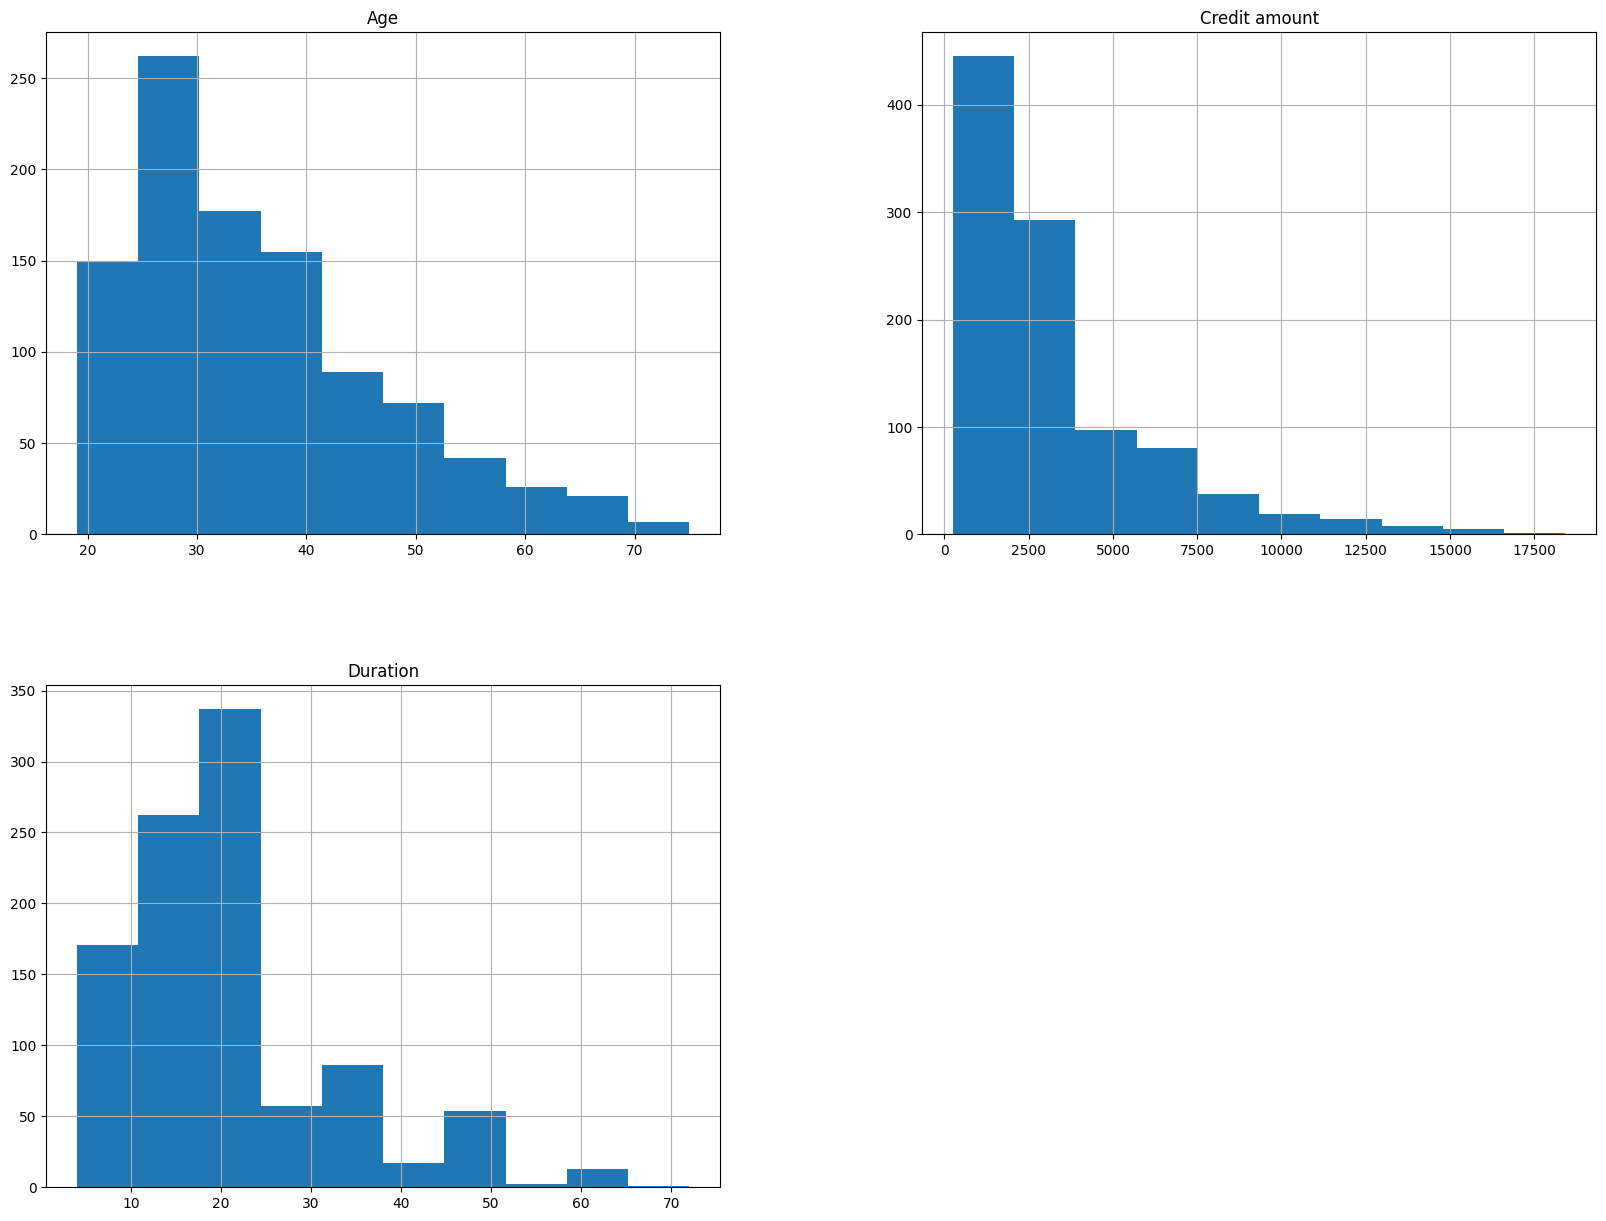

In [22]:
df[numerik].hist(figsize= (20, 15))

Visualisasi ini menampilkan hasil visualisasi grafik pada kolom numerik yaitu kolom **Age**, **Credit amount** dan **Duration**

- Pada kolom **Age** terjadi pelonjakan kenaikan dari umur 20 ke 25<br>
Umur 25 sampai 30 merupakan umur dengan jumlah nasabah terbanyak<br>
Rata-rata umur nasabah pengajuan kredit berada di rentang 20-40 tahun<br>
Berdasarkan grafik didapatkan bahwa, semakin tua umurnya semakin menurun grafik<br>
<b>Semakin tua umur, semakin sedikit nasabah yang mengajukan kredit atau pinjaman</b>

- Pada kolom **Credit amount** paling banyak yaitu pada jumlah credit amount 250	sampai 3000<br>
<b>Semakin besar credit amount semakin sedikit jumlah nasabahnya</b>

- Pada kolom **Duration** didapatkan durasi yang paling banyak diambil oleh nasabah yaitu dengan durasi 4 sampai 25 bulan<br>
Bulan 25 sampai 30 terdapat penurunan yang cukup signifikan<br>
Bulan lainnya terdapat perbedaan grafik yang cukup berbeda signifikan lebih sedikit

In [23]:
kategorik

Index(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Purpose'],
      dtype='object')

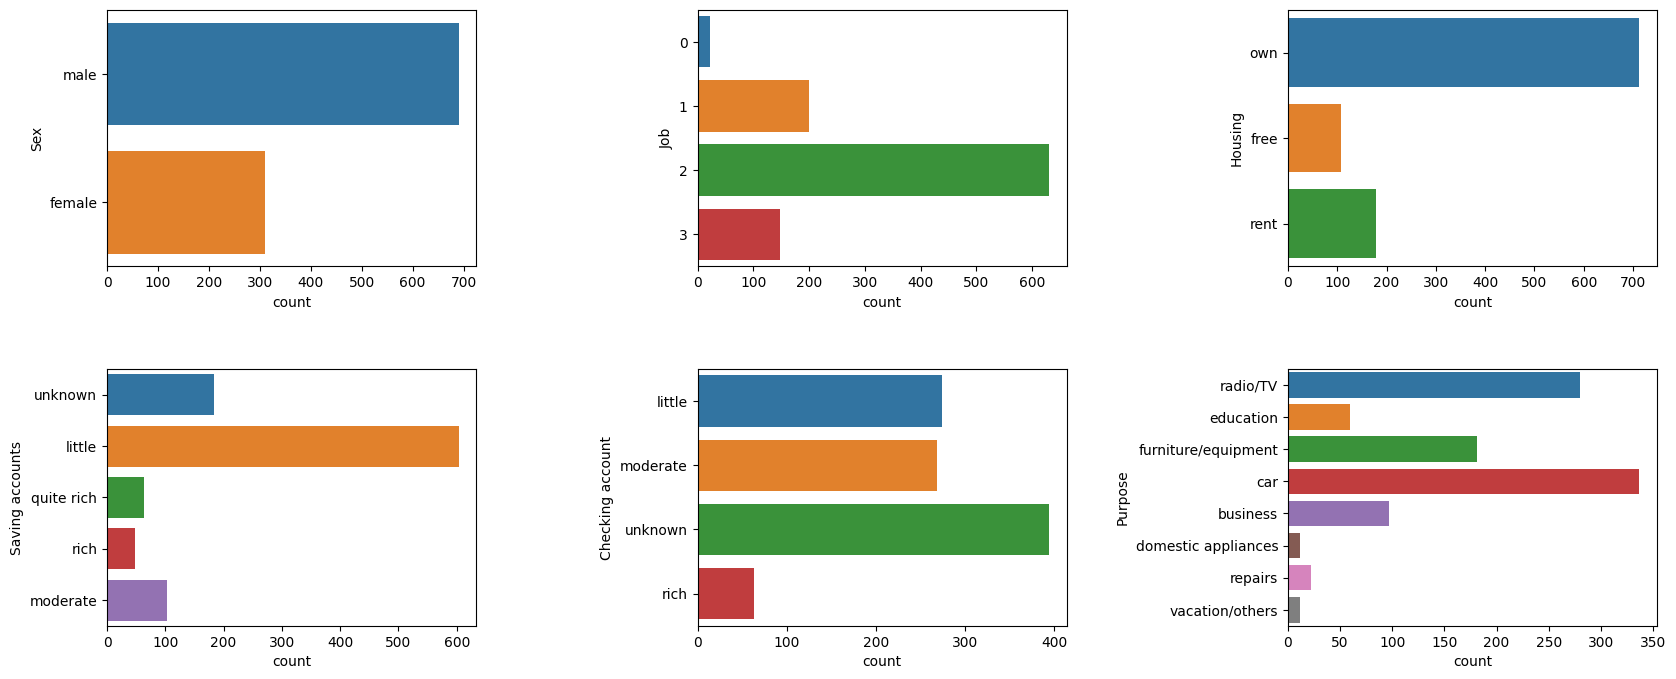

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

kolom = df[kategorik].columns
c = 0

for a in range(0, 2):
    for b in range(0, 3):
        if c < len(kolom):
            sns.countplot(y=kolom[c], data=df, ax=axes[a, b])
            c+=1
        else:
            # Menghapus subplot yang tidak digunakan
            fig.delaxes(axes[a, b])

# Menambahkan jarak antara subplot    
plt.subplots_adjust(wspace=0.6, hspace=0.4)
plt.show()

Visualisasi ini menampilkan hasil visualisasi grafik pada kolom kategorik yaitu kolom **Sex**, **Housing**, **Saving accounts**, **Checking account**, **Job** dan **Purpose**<br>

- Pada kolom **Sex** atau jenis kelamin Nasabah kredit bank lebih banyak dari gender laki-laki perbandingannya mencapai 7:3

- Pada kolom **Housing** atau Rumah Nasabah kredit bank paling banyak sudah memiliki rumah sendiri dan perbandingannya yaitu 7:1:2<br>
(milik(own) **:** bebas(free) **:** sewa(rent))

- Pada kolom **Saving accounts** atau Jumlah tabungan Nasabah kredit bank didominasi yang memiliki jumlah tabungan dengan jumlah sedikit dan nasabah dengan tabungan terbanyak berjumlah paling sedikit

- Pada kolom **Checking accounts** atau Jumlah tabungan Giro Nasabah kredit bank didominasi dengan nasabah yang tidak diketahui statusnya

- Pada kolom **Job** label 2 mendominasi dengan jumlah lebih dari 600 nasabah dan label 0 merupakan jumlah paling sedikit

- Pada kolom **Purpose** Nasabah kredit bank didominasi yang memiliki tujuan kredit yaitu untuk membeli mobil (car) dan 3 tujuan tertinggi nasabah dibawahnya yaitu:
  - radio/TV
  - furnitur/perlengkapan
  - bisnis.

Berikut visualisasi scatter plot pada 3 kolom numerik yang dikelompokkan berdasarkan jenis kelamin
- Age
- Credit amount
- Duration

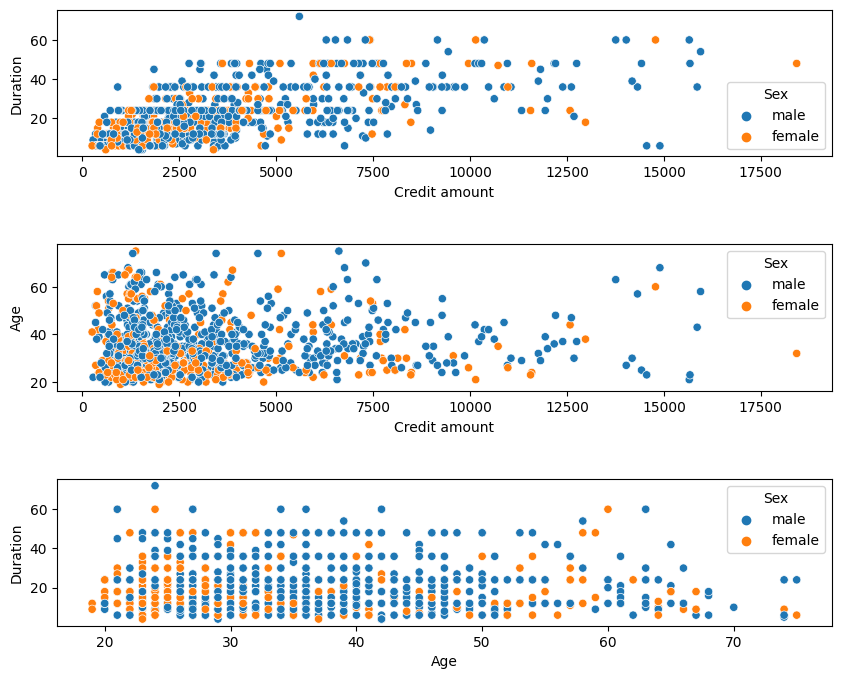

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
sns.scatterplot(x="Credit amount", y="Duration", hue='Sex', palette=None, data=df, ax=ax1)
sns.scatterplot(x="Credit amount", y="Age", hue='Sex', palette=None, data=df, ax=ax2)
sns.scatterplot(x="Age", y="Duration", hue='Sex', palette=None, data=df, ax=ax3)

plt.subplots_adjust(hspace=0.6)

#### **Grafik Outliers**

Berikut merupakan visualisasi boxplots untuk analisis rincian setiap **kolom  kategorik** dengan setiap **kolom numerik** untuk melihat data outliers

<b>Kolom purpose</b> dengan <b>Kolom Credit amount</b>

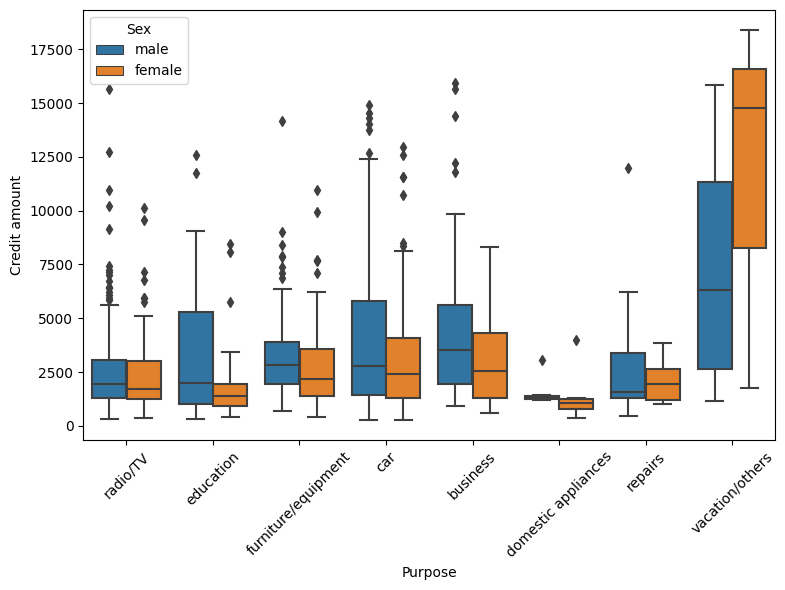

In [26]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Purpose', y='Credit amount', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=45)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

<b>Kolom purpose</b> dengan <b>Kolom Duration</b>

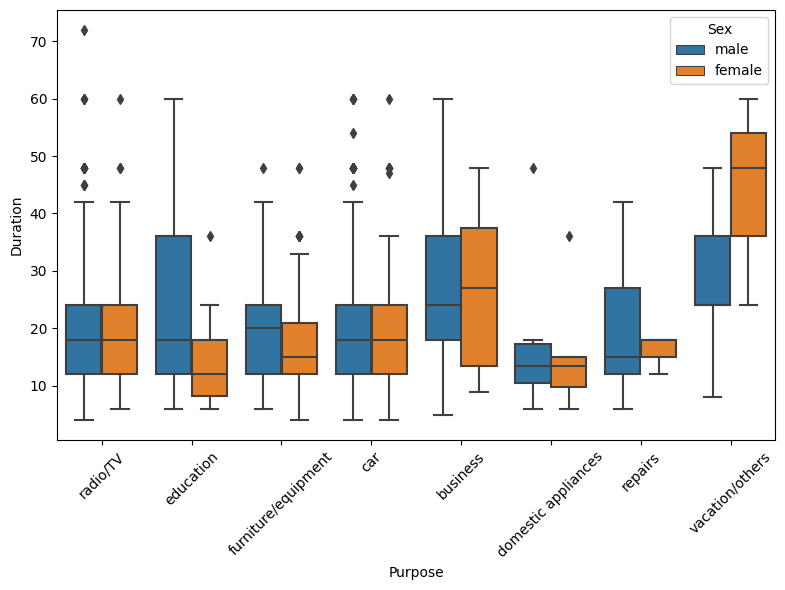

In [27]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Purpose', y='Duration', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=45)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

<b>Kolom Housing</b> dengan <b>Kolom Credit amount</b>

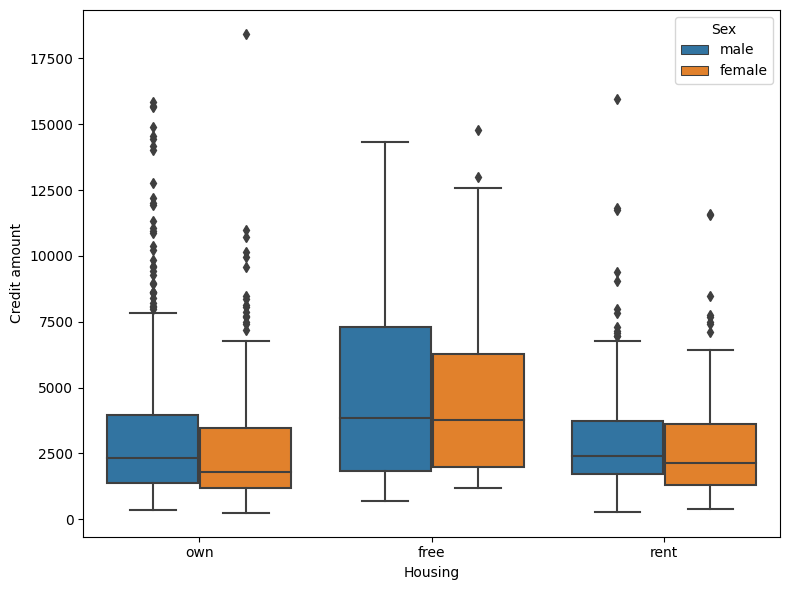

In [28]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Housing', y='Credit amount', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=0)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

<b>Kolom Housing</b> dengan <b>Kolom Duration</b>

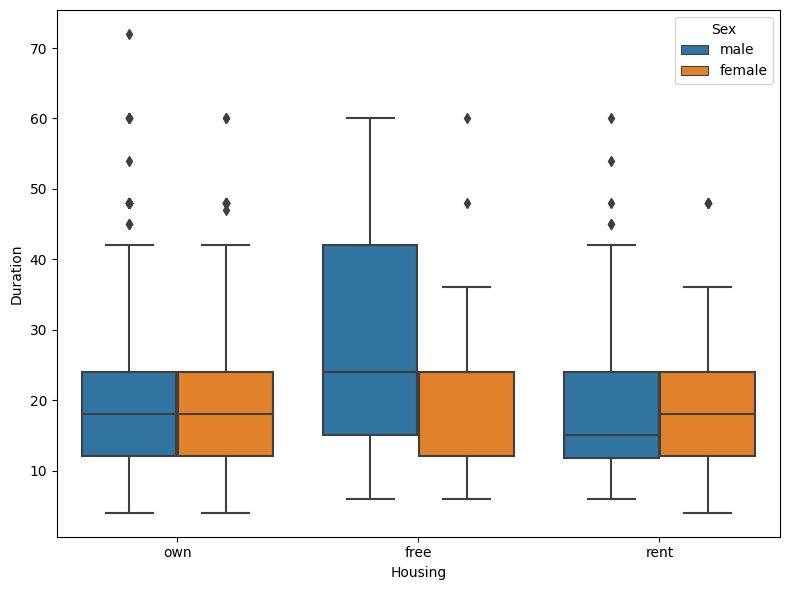

In [29]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Housing', y='Duration', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=0)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

<b>Kolom Job</b> dengan <b>Kolom Credit amount</b>

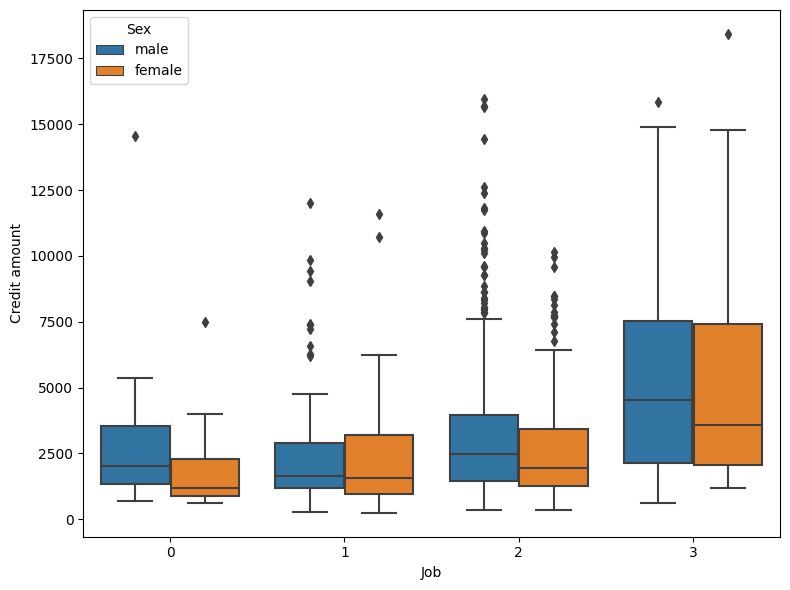

In [30]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Job', y='Credit amount', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=0)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

<b>Kolom Housing</b> dengan <b>Kolom Duration</b>

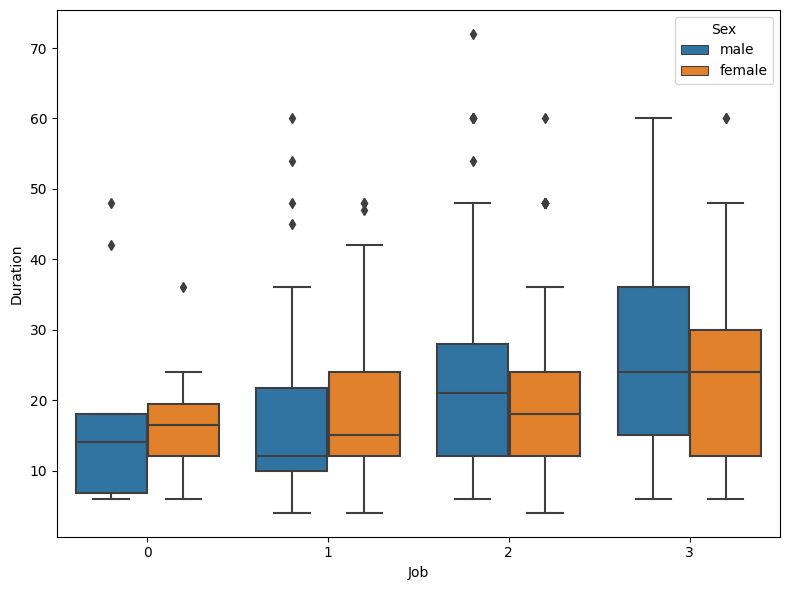

In [31]:
plt.figure(figsize=(8, 6))
box = sns.boxplot(x='Job', y='Duration', hue='Sex', data=df)
box.set_xticklabels(box.get_xticklabels(), rotation=0)
fig.subplots_adjust(bottom=0.2)
plt.tight_layout()

#### **Correlation Matrix**

Pada proses ini saya menggunakan tabel grafik korelasi matriks unutk mengetahui korelasi antara setiap kolom<br>
Terdapat kontras warna juga untuk mengetahui korelasi jika semakin berkorelasi warna nya akan semakin terang

<ipython-input-32-ee86416b3623>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


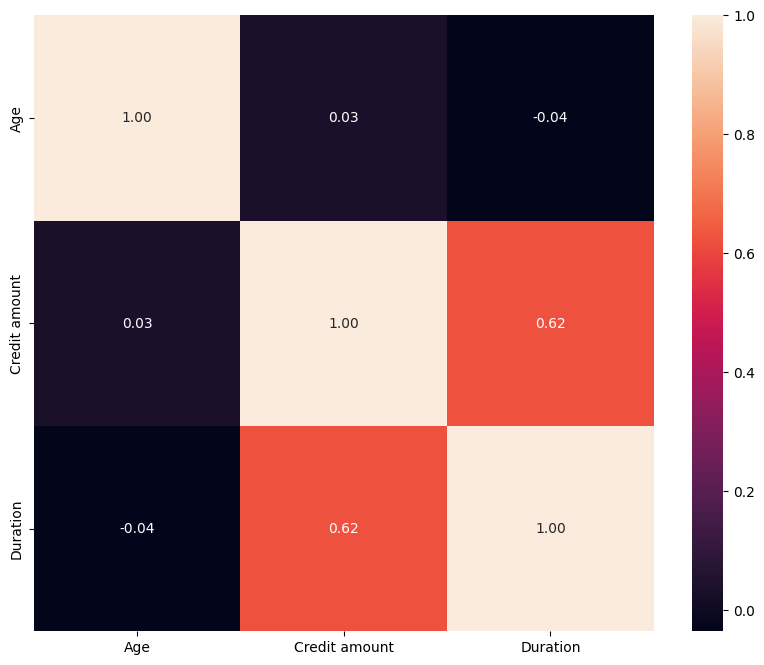

In [32]:
corr = df.corr()
plt.figure(figsize=(10,8));
sns.heatmap(corr, annot=True, fmt='.2f');

# Data Prepocessing

In [33]:
data_clean = df.copy()

Duplikasi Dataframe yang Awal

### **Normalisasi dengan Scaling Data**

In [34]:
df[numerik].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [35]:
scaler = StandardScaler()
data_clean['Credit amount'] = scaler.fit_transform(data_clean[['Credit amount']])
data_clean.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,unknown,little,-0.745131,6,radio/TV
1,22,female,2,own,little,moderate,0.949817,48,radio/TV
2,49,male,1,own,little,unknown,-0.416562,12,education
3,45,male,2,free,little,little,1.634247,42,furniture/equipment
4,53,male,2,free,little,little,0.566664,24,car


Melakukan Scaling pada **kolom Credit amount** karena memiliki nilai yang lumayan jauh antara **mean** dengan **median**<br>
Kolom tersebut memiliki skala yang berbeda-beda atau rentang yang signifikan

In [36]:
df_kprototypes = data_clean.copy()

Duplikasi Dataframe untuk digunakan pada Algoritma KPrototypes nantinya

### **Encoding dengan One-Hot Encoder dan Label Encoder**

In [37]:
data_clean[kategorik].nunique()

Sex                 2
Job                 4
Housing             3
Saving accounts     5
Checking account    4
Purpose             8
dtype: int64

Melihat jumlah data unik pada kolom kategorik

In [38]:
kolom1 = data_clean[kategorik].columns[data_clean[kategorik].nunique() <= 4]
kolom2 = data_clean[kategorik].columns[data_clean[kategorik].nunique() > 4]

print('Kolom pada Variabel kolom1:', '\n', kolom1, '\n')
print('Kolom pada Variabel kolom2:', '\n', kolom2)

Kolom pada Variabel kolom1: 
 Index(['Sex', 'Job', 'Housing', 'Checking account'], dtype='object') 

Kolom pada Variabel kolom2: 
 Index(['Saving accounts', 'Purpose'], dtype='object')


Memisahkan kolom menjadi 2 bagian
- Variabel **kolom1** untuk menyimpan nama kolom dengan jumlah data unik <= 4
- Variabel **kolom2** untuk menyimpan nama kolom dengan jumlah data unik > 4

Melakukan **Label Encoding** pada kolom dengan jumlah data unik > 3

In [39]:
label_encoder = LabelEncoder()

for kolom in kategorik:
    data_clean[kolom] = label_encoder.fit_transform(data_clean[[kolom]])

data_clean.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,-0.745131,6,5
1,22,0,2,1,0,1,0.949817,48,5
2,49,1,1,1,0,3,-0.416562,12,3
3,45,1,2,0,0,0,1.634247,42,4
4,53,1,2,0,0,0,0.566664,24,1


Melakukan **Get Dummies** atau **One-Hot Encoding** pada kolom dengan jumlah data unik <= 4 yaitu
- Kolom **Sex**
- Kolom **Job**
- Kolom **Housing**
- Kolom **Checking account**

In [40]:
data_clean = pd.get_dummies(data_clean, columns=kolom1, dtype=int)
data_clean.head()

,Age,Saving accounts,Credit amount,Duration,Purpose,Sex_0,Sex_1,Job_0,Job_1,Job_2,Job_3,Housing_0,Housing_1,Housing_2,Checking account_0,Checking account_1,Checking account_2,Checking account_3
0,67,4,-0.745131,6,5,0,1,0,0,1,0,0,1,0,1,0,0,0
1,22,0,0.949817,48,5,1,0,0,0,1,0,0,1,0,0,1,0,0
2,49,0,-0.416562,12,3,0,1,0,1,0,0,0,1,0,0,0,0,1
3,45,0,1.634247,42,4,0,1,0,0,1,0,1,0,0,1,0,0,0
4,53,0,0.566664,24,1,0,1,0,0,1,0,1,0,0,1,0,0,0


Menggunakan Label Encoding pada Kolom **Saving accounts** dan **Purpose**<br>
Karena jumlah data unik pada kolom tersebut cukup banyak atau lebih dari 4<br>
Apabila menggunakan One-Hot Encoding akan menyebabkan banyak kolom baru yang terbentuk yang membuat dataset menjadi tidak efisien

In [41]:
data_clean.dtypes

Age                     int64
Saving accounts         int64
Credit amount         float64
Duration                int64
Purpose                 int64
Sex_0                   int64
Sex_1                   int64
Job_0                   int64
Job_1                   int64
Job_2                   int64
Job_3                   int64
Housing_0               int64
Housing_1               int64
Housing_2               int64
Checking account_0      int64
Checking account_1      int64
Checking account_2      int64
Checking account_3      int64
dtype: object

# Model Preparation

#### **Menyimpan Dataset yang sudah bersih**

In [42]:
data_clean.to_csv(path_or_buf='/content/drive/MyDrive/Colab Notebooks/Machine Learning/Clustering/Bank Customer Segmentation/clean_data_preprocessing.csv', index=False)
df.to_csv(path_or_buf='/content/drive/MyDrive/Colab Notebooks/Machine Learning/Clustering/Bank Customer Segmentation/clean_data.csv', index=False)

Menyimpan data dengan format CSV<br>
- Dengan nama **clean_data.csv** untuk menyimpan data dari **variable df**<br>
- Dengan nama **clean_data_preprocessing.csv** untuk menyimpan data dari **variable data_clean**

### **Data Preparation**

In [43]:
print('Kolom pada Dataset', '\n', data_clean.columns, '\n')
print('Kolom Kategorik', '\n', kategorik, '\n')
print('Kolom Kategorik', '\n', numerik)

Kolom pada Dataset 
 Index(['Age', 'Saving accounts', 'Credit amount', 'Duration', 'Purpose',
       'Sex_0', 'Sex_1', 'Job_0', 'Job_1', 'Job_2', 'Job_3', 'Housing_0',
       'Housing_1', 'Housing_2', 'Checking account_0', 'Checking account_1',
       'Checking account_2', 'Checking account_3'],
      dtype='object') 

Kolom Kategorik 
 Index(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Purpose'],
      dtype='object') 

Kolom Kategorik 
 Index(['Age', 'Credit amount', 'Duration'], dtype='object')


In [44]:
split_kategorik = '|'.join(kategorik)
kolom_kategorik = split_kategorik
kolom1 = data_clean.columns
kolom2 = df.columns
kolom_kategorik

'Sex|Job|Housing|Saving accounts|Checking account|Purpose'

In [45]:
indeks_kategorik = [i for i, nama_kolom in enumerate(kolom1) if re.search(kolom_kategorik, nama_kolom)]
indeks_kategorik

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Mencari Index Kolom Kategorik menggunakan Regular Expression<br>
Kolom kategorik berada pada index **[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]**

In [46]:
indeks_kategorik2 = [i for i, nama_kolom in enumerate(kolom2) if re.search(kolom_kategorik, nama_kolom)]
indeks_kategorik2

[1, 2, 3, 4, 5, 8]

**Membuat Dataframe Baru** untuk menampung Hasil Evaluasi terbaik

In [47]:
hasil = pd.DataFrame(columns=['Algoritma', 'Jumlah Klaster', 'Jenis Evaluasi', 'Hasil Score'])

### **Mencari Jumlah Cluster**
Menggunakan Sillhoutte Score dan Metode Ellbow 

Pemodelan menggunakan algoritma 
- **K-Prototypes**
- **Agglomerative Clustering**
- **K-Means**

#### Menggunakan **Metode Elbow**

Metode ini melibatkan plot nilai inersia sebagai fungsi dari jumlah klaster yang akan digunakan<br>
Inersia mengukur sejauh mana titik-titik dalam satu klaster berdekatan satu sama lain<br><br>
**Pada plot, kita akan mencari "siku" atau "elbow" di kurva inersia**, yang menunjukkan penurunan yang signifikan dalam peningkatan inersia<br>
Jumlah klaster di titik tersebut dapat dipilih sebagai jumlah klaster yang optimal

Algoritma **K-Means** Clustering

Text(0.5, 0, 'Jumlah Klaster')

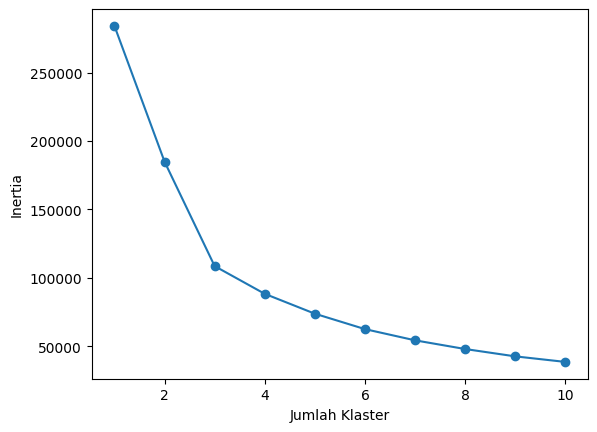

In [48]:
klaster = range(1, 11)
scores = []

for k in klaster:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    member = kmeans.fit_predict(data_clean, y=None) 
    scores.append(kmeans.inertia_)

plt.figure()
plt.plot(klaster, scores, marker='o')
plt.ylabel('Inertia')
plt.xlabel('Jumlah Klaster')

**Jumlah klaster yang terbentuk adalah 3**

#### Menggunakan **Sillhoutte Score**

Metrik ini mengukur sejauh mana setiap sampel dalam suatu klaster berada dalam klaster yang sesuai dibandingkan dengan klaster lainnya<br>
Rentang nilai Silhouette Score adalah -1 hingga 1, di mana **nilai yang lebih tinggi** menunjukkan **klaster yang lebih baik** terpisah dan lebih kompak

Algoritma **K-Means** Clustering

In [49]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    member = kmeans.fit_predict(data_clean, y=None) 

    # Hitung Silhouette Score
    silhouette_avg = silhouette_score(data_clean, member)
    
    # Simpan nilai Silhouette Score
    scores.append(silhouette_avg)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, Silhouette Score = {score}")

Jumlah Klaster = 2, Silhouette Score = 0.4030772458971211
Jumlah Klaster = 3, Silhouette Score = 0.4198685783488957
Jumlah Klaster = 4, Silhouette Score = 0.3250987201512564
Jumlah Klaster = 5, Silhouette Score = 0.3204883686283588
Jumlah Klaster = 6, Silhouette Score = 0.3244241288549582
Jumlah Klaster = 7, Silhouette Score = 0.3269142003182245
Jumlah Klaster = 8, Silhouette Score = 0.33224603462350516
Jumlah Klaster = 9, Silhouette Score = 0.326257120830957
Jumlah Klaster = 10, Silhouette Score = 0.3182125904496827


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai Silhoutte Score yang tertinggi yaitu : 0,4199

In [50]:
hasil = hasil.append({'Algoritma': 'KMeans', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-50-74fe05369027>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'KMeans', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)


Algoritma **K-Prototypes** Clustering dengan Data Numerik

In [51]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kprototypes = KPrototypes(n_clusters=k, n_init=50)
    member = kprototypes.fit_predict(data_clean, y=None, categorical=indeks_kategorik)  # Menggunakan indeks kolom kategorikal
    
    # Hitung Silhouette Score
    silhouette_avg = silhouette_score(data_clean, member)
    
    # Simpan nilai Silhouette Score
    scores.append(silhouette_avg)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, Silhouette Score = {score}")

Jumlah Klaster = 2, Silhouette Score = 0.4030772458971211
Jumlah Klaster = 3, Silhouette Score = 0.41973956820871716
Jumlah Klaster = 4, Silhouette Score = 0.3250987201512564
Jumlah Klaster = 5, Silhouette Score = 0.3241013230142231
Jumlah Klaster = 6, Silhouette Score = 0.32462216722409387
Jumlah Klaster = 7, Silhouette Score = 0.3268754427508916
Jumlah Klaster = 8, Silhouette Score = 0.3285808531385658
Jumlah Klaster = 9, Silhouette Score = 0.32377684301458215
Jumlah Klaster = 10, Silhouette Score = 0.31765120282376


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai Silhoutte Score yang tertinggi yaitu : 0,4197

In [52]:
hasil = hasil.append({'Algoritma': 'KPrototypes Numerik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-52-c454ba294acd>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'KPrototypes Numerik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)


Algoritma **K-Prototypes** Clustering dengan Data Kategorik

In [53]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kprototypes = KPrototypes(n_clusters=k, n_init=50)
    member = kprototypes.fit_predict(df_kprototypes, y=None, categorical=indeks_kategorik2)  # Menggunakan indeks kolom kategorikal
    
    # Hitung Silhouette Score
    silhouette_avg = silhouette_score(data_clean, member)
    
    # Simpan nilai Silhouette Score
    scores.append(silhouette_avg)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, Silhouette Score = {score}")

Jumlah Klaster = 2, Silhouette Score = 0.4030772458971211
Jumlah Klaster = 3, Silhouette Score = 0.41973956820871716
Jumlah Klaster = 4, Silhouette Score = 0.3250987201512564
Jumlah Klaster = 5, Silhouette Score = 0.3202942057999589
Jumlah Klaster = 6, Silhouette Score = 0.32462216722409387
Jumlah Klaster = 7, Silhouette Score = 0.3269142003182245
Jumlah Klaster = 8, Silhouette Score = 0.32879291835292646
Jumlah Klaster = 9, Silhouette Score = 0.3228446577152811
Jumlah Klaster = 10, Silhouette Score = 0.3179217615851237


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai Silhoutte Score yang tertinggi yaitu : 0,4197

In [54]:
hasil = hasil.append({'Algoritma': 'KPrototypes Kategorik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-54-ae8c0d45e9c0>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'KPrototypes Kategorik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)


Algoritma **Agglomerative Clustering**

In [55]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward')
    member = agglomerative.fit_predict(data_clean, y=None) 

    # Hitung Silhouette Score
    silhouette_avg = silhouette_score(data_clean, member)
    
    # Simpan nilai Silhouette Score
    scores.append(silhouette_avg)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, Silhouette Score = {score}")

Jumlah Klaster = 2, Silhouette Score = 0.4063198351034115
Jumlah Klaster = 3, Silhouette Score = 0.41170968380774225
Jumlah Klaster = 4, Silhouette Score = 0.28571777517973374
Jumlah Klaster = 5, Silhouette Score = 0.2644132508788837
Jumlah Klaster = 6, Silhouette Score = 0.26830864817582767
Jumlah Klaster = 7, Silhouette Score = 0.2682529317782905
Jumlah Klaster = 8, Silhouette Score = 0.2745914702787744
Jumlah Klaster = 9, Silhouette Score = 0.29113411738167894
Jumlah Klaster = 10, Silhouette Score = 0.28369242375844855


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai Silhoutte Score yang tertinggi yaitu : 0,4117

In [56]:
hasil = hasil.append({'Algoritma': 'AgglomerativeClustering', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-56-b564e9d837ca>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'AgglomerativeClustering', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'Silhoutte Score', 'Hasil Score': max(scores)}, ignore_index=True)


#### Menggunakan **CH Index Score**

**Semakin tinggi** nilai CH Index, **Semakin baik** hasil klasteringnya

Algoritma **K-Means** Clustering

In [57]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    member = kmeans.fit_predict(data_clean, y=None) 

    # Hitung CH Index
    ch_score = calinski_harabasz_score(data_clean, member)

    # Simpan nilai CH Index
    scores.append(ch_score)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, CH Index Score = {score}")

Jumlah Klaster = 2, CH Index Score = 534.9249992950307
Jumlah Klaster = 3, CH Index Score = 804.6475299308156
Jumlah Klaster = 4, CH Index Score = 734.6064274908887
Jumlah Klaster = 5, CH Index Score = 707.2670099499118
Jumlah Klaster = 6, CH Index Score = 702.5874557986047
Jumlah Klaster = 7, CH Index Score = 697.7359249665636
Jumlah Klaster = 8, CH Index Score = 695.0130452270536
Jumlah Klaster = 9, CH Index Score = 699.2236648311094
Jumlah Klaster = 10, CH Index Score = 697.5229050592723


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai CH Index yang tertinggi yaitu : 804,6475

In [58]:
hasil = hasil.append({'Algoritma': 'KMeans', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-58-afb325c0628b>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'KMeans', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)


Algoritma **K-Prototypes** Clustering dengan Data Numerik

In [59]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kprototypes = KPrototypes(n_clusters=k, n_init=50)
    member = kprototypes.fit_predict(data_clean, y=None, categorical=indeks_kategorik)  # Menggunakan indeks kolom kategorikal

    # Hitung CH Index
    ch_score = calinski_harabasz_score(data_clean, member)

    # Simpan nilai CH Index
    scores.append(ch_score)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, CH Index Score = {score}")

Jumlah Klaster = 2, CH Index Score = 534.9249992950307
Jumlah Klaster = 3, CH Index Score = 804.6402095388436
Jumlah Klaster = 4, CH Index Score = 734.6064274908888
Jumlah Klaster = 5, CH Index Score = 706.7213898756281
Jumlah Klaster = 6, CH Index Score = 702.5288964067429
Jumlah Klaster = 7, CH Index Score = 697.7359249665637
Jumlah Klaster = 8, CH Index Score = 696.5974080315739
Jumlah Klaster = 9, CH Index Score = 698.8151039924587
Jumlah Klaster = 10, CH Index Score = 696.5994813552429


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai CH Index yang tertinggi yaitu : 804,6402

In [60]:
hasil = hasil.append({'Algoritma': 'KPrototypes Numerik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-60-fbba00fd4802>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'KPrototypes Numerik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)


Algoritma **K-Prototypes** Clustering dengan Data Kategorik

In [61]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    kprototypes = KPrototypes(n_clusters=k, n_init=50)
    member = kprototypes.fit_predict(df_kprototypes, y=None, categorical=indeks_kategorik2)  # Menggunakan indeks kolom kategorikal

    # Hitung CH Index
    ch_score = calinski_harabasz_score(data_clean, member)

    # Simpan nilai CH Index
    scores.append(ch_score)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, CH Index Score = {score}")

Jumlah Klaster = 2, CH Index Score = 534.9249992950307
Jumlah Klaster = 3, CH Index Score = 804.6402095388437
Jumlah Klaster = 4, CH Index Score = 734.6064274908888
Jumlah Klaster = 5, CH Index Score = 707.1472113555229
Jumlah Klaster = 6, CH Index Score = 702.5288964067429
Jumlah Klaster = 7, CH Index Score = 697.7359249665639
Jumlah Klaster = 8, CH Index Score = 696.6095664178434
Jumlah Klaster = 9, CH Index Score = 698.0389741843509
Jumlah Klaster = 10, CH Index Score = 695.9223931597662


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai CH Index yang tertinggi yaitu : 804.6402

In [ ]:
hasil = hasil.append({'Algoritma': 'KPrototypes Kategorik', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)

Algoritma **Agglomerative Clustering**

In [69]:
klaster = range(2, 11)
scores = []

for k in klaster:
    # Terapkan algoritma k-prototypes
    agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward')
    member = agglomerative.fit_predict(data_clean, y=None) 

    # Hitung CH Index
    ch_score = calinski_harabasz_score(data_clean, member)

    # Simpan nilai CH Index
    scores.append(ch_score)

# Menampilkan hasil
for k, score in zip(klaster, scores):
    print(f"Jumlah Klaster = {k}, CH Index Score = {score}")

Jumlah Klaster = 2, CH Index Score = 515.2406000015084
Jumlah Klaster = 3, CH Index Score = 763.9532553943064
Jumlah Klaster = 4, CH Index Score = 672.5999390789182
Jumlah Klaster = 5, CH Index Score = 605.1759708088218
Jumlah Klaster = 6, CH Index Score = 584.0275403482173
Jumlah Klaster = 7, CH Index Score = 570.1539031648558
Jumlah Klaster = 8, CH Index Score = 580.1088311313315
Jumlah Klaster = 9, CH Index Score = 591.0836343589148
Jumlah Klaster = 10, CH Index Score = 601.8040980122038


**Jumlah klaster yang terbaik adalah 3**<br>
Karena menghasilkan nilai CH Index yang tertinggi yaitu : 763,9533

In [64]:
hasil = hasil.append({'Algoritma': 'AgglomerativeClustering', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)

<ipython-input-64-7d5c27f00378>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hasil = hasil.append({'Algoritma': 'AgglomerativeClustering', 'Jumlah Klaster': 3, 'Jenis Evaluasi': 'CH Index Score', 'Hasil Score': max(scores)}, ignore_index=True)


### Mencari Linkage pada **Algoritma AgglomerativeClustering**

Menggunakan nilai cluster sebesar 3

#### Menggunakan **CH Index Score**

In [65]:
linkage = ['ward', 'single', 'complete']
scores = []

for i in linkage:
    # Terapkan algoritma k-prototypes
    agglomerative = AgglomerativeClustering(n_clusters=3, linkage=i)
    member = agglomerative.fit_predict(data_clean, y=None) 

    # Hitung CH Index
    ch_score = calinski_harabasz_score(data_clean, member)

    # Simpan nilai CH Index
    scores.append(ch_score)

# Menampilkan hasil
for i, score in zip(linkage, scores):
    print(f"Linkage = {i}, CH Index Score = {score}")


Linkage = ward, CH Index Score = 763.9532553943064
Linkage = single, CH Index Score = 7.268772316350729
Linkage = complete, CH Index Score = 240.62209417017695


Linkage yang terbaik adalah **ward**, karena menghasilkan nilai CH Index Score sebesar 763,9532

#### Menggunakan **Silhoutte Score**

In [66]:
linkage = ['ward', 'single', 'complete']
scores = []

for i in linkage:
    # Terapkan algoritma k-prototypes
    agglomerative = AgglomerativeClustering(n_clusters=3, linkage=i)
    member = agglomerative.fit_predict(data_clean, y=None) 

   # Hitung Silhouette Score
    silhouette_avg = silhouette_score(data_clean, member)
    
    # Simpan nilai Silhouette Score
    scores.append(silhouette_avg)

# Menampilkan hasil
for i, score in zip(linkage, scores):
    print(f"Linkage = {i}, Silhoutte Score = {score}")


Linkage = ward, Silhoutte Score = 0.41170968380774225
Linkage = single, Silhoutte Score = 0.40346395610044467
Linkage = complete, Silhoutte Score = 0.3619517429468341


Linkage yang terbaik adalah **ward**, karena menghasilkan nilai Sillhoutte Score sebesar 0,4117

# Kesimpulan

Berikut merupakan Hasil Evaluasi serta jumlah klaster terbaik yang digunakan pada setiap Algoritma

In [68]:
hasil

,Algoritma,Jumlah Klaster,Jenis Evaluasi,Hasil Score
0,KMeans,3,Silhoutte Score,0.419869
1,KPrototypes Numerik,3,Silhoutte Score,0.419740
2,KPrototypes Kategorik,3,Silhoutte Score,0.419740
3,AgglomerativeClustering,3,Silhoutte Score,0.411710
4,KMeans,3,CH Index Score,804.647530
5,KPrototypes Numerik,3,CH Index Score,804.640210
6,KPrototypes Kategorik,3,CH Index Score,804.640210
7,AgglomerativeClustering,3,CH Index Score,763.953255


Jumlah Cluster yang digunakan yaitu **3 Cluster** berdasarkan hasil dari Evaluasi Silhoutte Score dan CH Index Score<br>
Jenis Linkage yang digunakan pada Algoritma AgglomerativeClustering yaitu **ward**